In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.cnn as cnn
import feature.simulated_dataset as simulated_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import extract.dinuc_shuffle as dinuc_shuffle
import extract.importance as importance
import analysis.motif_util as motif_util
import plot.plot_motifs as plot_motifs
import os
import json
import torch
import captum.attr
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import logomaker
import scipy.spatial.distance
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
model_path = os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/standard_cnn/3/last_ckpt.pth")
motif_config_path = os.path.join(base_path, "data/simulations/configs/tal_gata_exp_mix_config.json")
neg_motif_config_path = None

In [6]:
# model_path = os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/standard_cnn/1/last_ckpt.pth")
# motif_config_path = os.path.join(base_path, "data/simulations/configs/rest_exp_both_config.json")
# neg_motif_config_path = None

In [7]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/attribution_scores"
os.makedirs(figures_out_path, exist_ok=True)

### Import model and create data loader

In [8]:
model = model_util.load_model(
    cnn.ConvNet, model_path
).to(DEVICE)

In [9]:
data_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 1024,
        "num_batches": 1,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path,
        "negative_ratio": 0,
        "return_configs": True
    }
).result

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - root - Added new config entry: "return_configs"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14e1ea79b230>
INFO - sim_dataset - Completed after 0:00:00


In [10]:
# Import motif PFMs
with open(motif_config_path, "r") as f:
    motif_files = json.load(f)["motif_files"]
motif_pfms = motif_util.import_meme_motifs(motif_files)

### Run model

In [11]:
_, _, model_outputs, _, _, input_data = \
    train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)

	Loss: 1.0561: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


In [12]:
input_one_hots, _, input_configs = input_data

### Compute importance scores

In [13]:
# Integrated gradients
ig_explainer = captum.attr.IntegratedGradients(model)
ig_impscores = []
for one_hot in tqdm.notebook.tqdm(input_one_hots):
    backgrounds = dinuc_shuffle.dinuc_shuffle(one_hot, 1)
    one_hot = torch.tensor(one_hot).to(DEVICE).float()[None]
    backgrounds = torch.tensor(backgrounds).to(DEVICE).float()
    scores = ig_explainer.attribute(one_hot, backgrounds).detach().cpu().numpy()
    ig_impscores.append(scores)
ig_impscores = np.concatenate(ig_impscores)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [14]:
# DeepLIFTShap
shap_impscores = importance.compute_shap_scores(model, input_one_hots)

  0%|                                                                                                                                | 0/1024 [00:00<?, ?it/s]/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:09<00:00, 104.80it/s]


In [15]:
# In silico mutagenesis
ism_impscores = importance.compute_ism_scores(model, input_one_hots)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:16<00:00, 62.10it/s]


### Plot importance scores

In [16]:
# # Plot some random examples
# num_to_plot = 5
# center_slice = slice(175, 325)
# fig, ax = plt.subplots(nrows=num_to_plot, ncols=3, figsize=(60, 4 * num_to_plot))
# for ex_i, track_i in enumerate(np.random.choice(len(input_one_hots), size=num_to_plot, replace=False)):
#     plot_motifs.create_dna_logo(ig_impscores[track_i, center_slice] * input_one_hots[track_i, center_slice], ax=ax[ex_i, 0])
#     plot_motifs.create_dna_logo(shap_impscores[track_i, center_slice] * input_one_hots[track_i, center_slice], ax=ax[ex_i, 1])
#     plot_motifs.create_dna_logo(ism_impscores[track_i, center_slice] * input_one_hots[track_i, center_slice], ax=ax[ex_i, 2])
# ax[0, 0].set_title("Integrated gradients")
# ax[0, 1].set_title("DeepLIFTShap")
# ax[0, 2].set_title("in silico mutagenesis")
# plt.show()

In [17]:
# Find examples of ISM which have the saturation effect
imp_frac_thresh = 0.7
center_slice = slice(175, 325)
ism_sat_inds = []
for track_i in range(len(input_one_hots)):
    start, config, revcomp = input_configs[track_i]
    if len(config) != 3:
        # We only want those with 2 motifs
        continue

    if revcomp:
        config = config[::-1]
        start = len(input_one_hots[track_i]) - \
            sum([len(motif_pfms[key]) if type(key) is str else key for key in config]) - \
            start
    
    scores = ism_impscores[track_i] * input_one_hots[track_i]
    scores_flat = np.sum(scores, axis=1)

    # Gather the importance scores under the true motif positions
    motif_imps = []
    motif_ints = []
    for key in config:
        if type(key) is int:
            start += key
        else:
            motif_ints.append((start, start + len(motif_pfms[key])))
            motif_imps.append(scores_flat[start : start + len(motif_pfms[key])])
            start += len(motif_pfms[key])

    # Look for situations where maximum importance of each motif did not surpass
    # some fraction of maximum importance
    thresh = np.max(scores_flat) * imp_frac_thresh
    if all(np.max(imps) < thresh for imps in motif_imps):
        # fig, ax = plt.subplots(figsize=(20, 4))
        # plot_motifs.create_dna_logo(
        #     scores[center_slice], ax=ax,
        #     highlights=[(s - center_slice.start, e - center_slice.start) for s, e in motif_ints]
        # )
        # plt.show()
        ism_sat_inds.append(track_i)

print(ism_sat_inds)

[433, 593, 711, 752, 761, 830]


In [18]:
# Compute disagreement of DeepLIFTShap and integrated gradients at motifs
ig_shap_conflicts = []
for track_i in range(len(input_one_hots)):
    start, config, revcomp = input_configs[track_i]
    
    if revcomp:
        config = config[::-1]
        start = len(input_one_hots[track_i]) - \
            sum([len(motif_pfms[key]) if type(key) is str else key for key in config]) - \
            start
    
    ig_scores_flat = np.sum(ig_impscores[track_i] * input_one_hots[track_i], axis=1)
    shap_scores_flat = np.sum(shap_impscores[track_i] * input_one_hots[track_i], axis=1)

    # Gather the importance scores under the true motif positions
    conflicts = []
    for key in config:
        if type(key) is int:
            start += key
        else:
            ig_imps = ig_scores_flat[start : start + len(motif_pfms[key])]
            shap_imps = shap_scores_flat[start : start + len(motif_pfms[key])]
            conflicts.append(scipy.spatial.distance.cosine(ig_imps, shap_imps))
    ig_shap_conflicts.append(np.mean(conflicts))

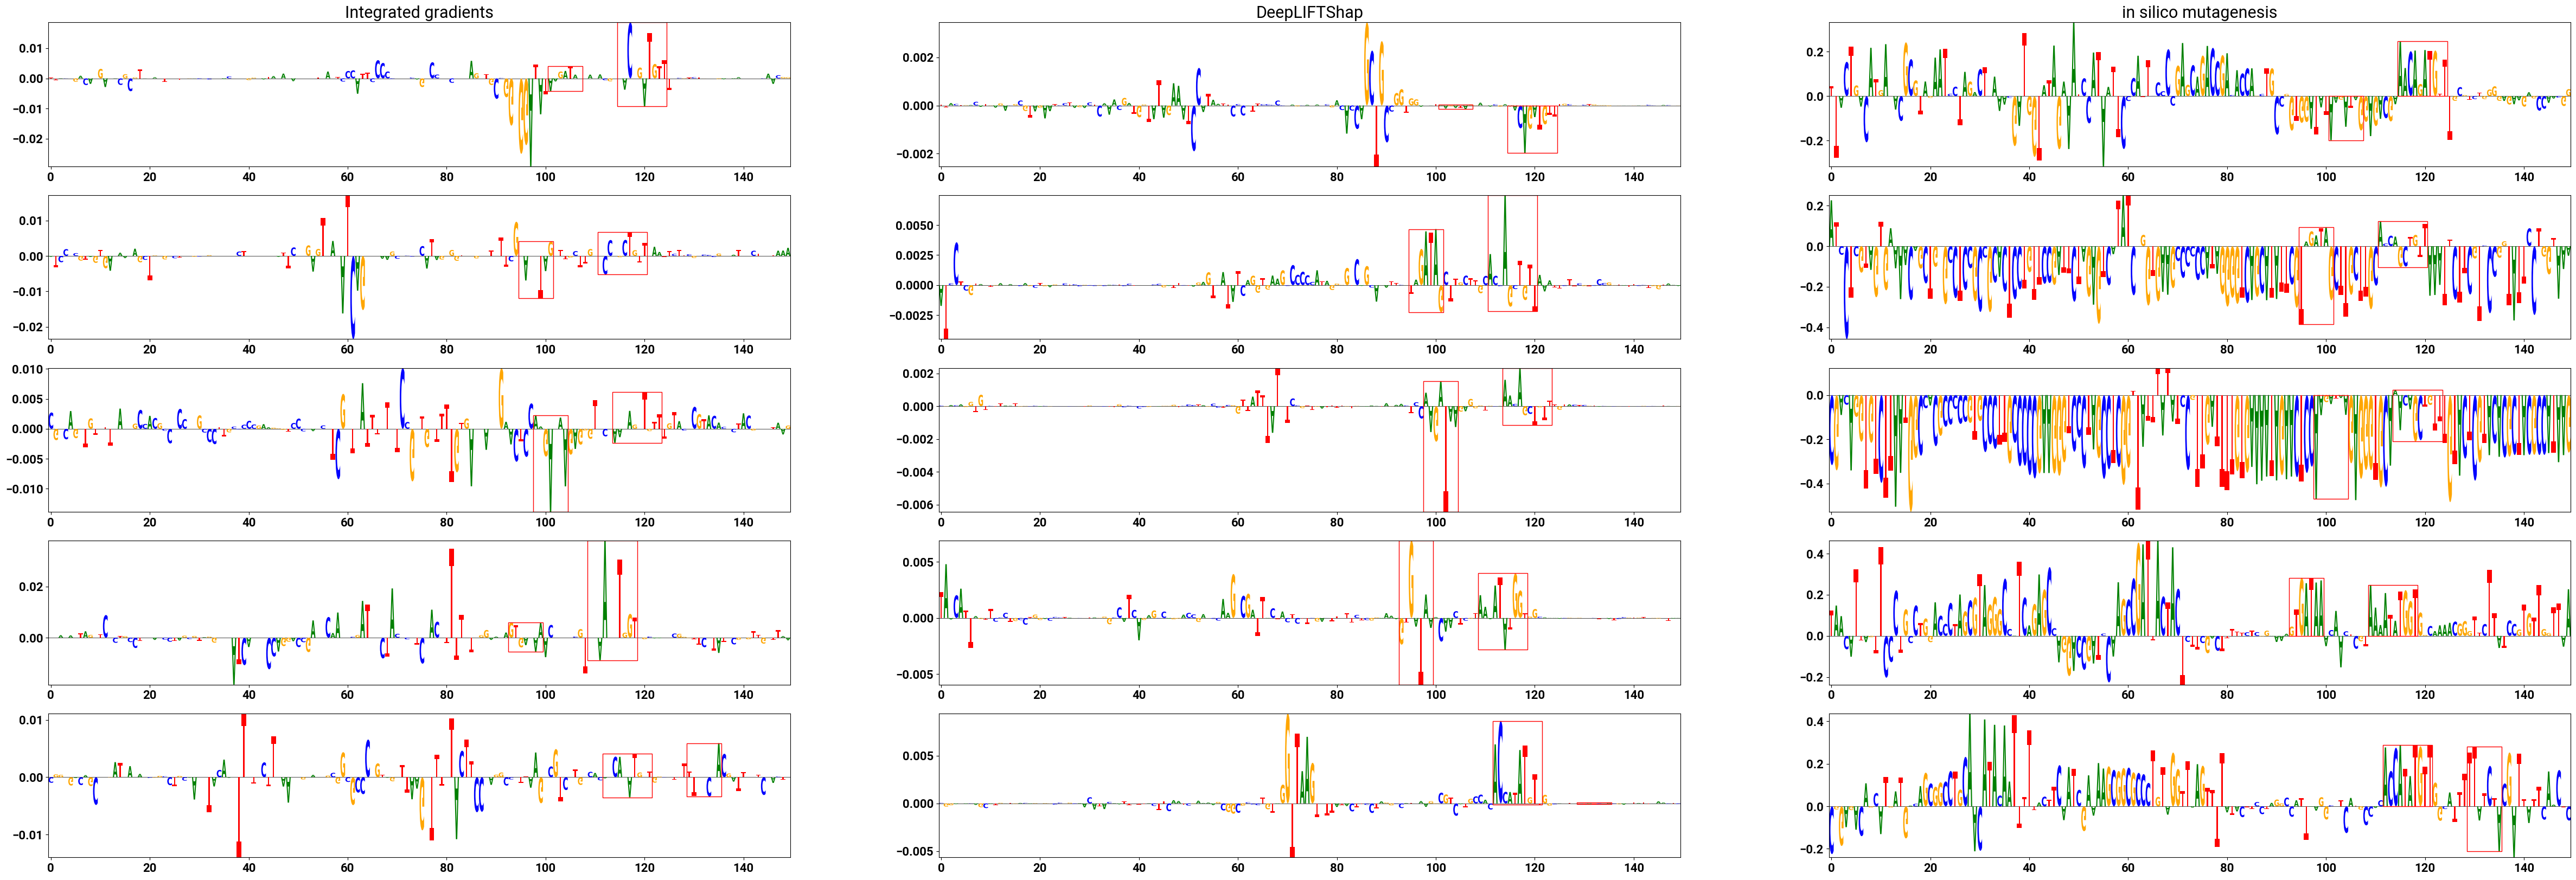

In [19]:
# Plot some specific tracks
num_to_plot = 5
inds_to_plot = sorted(ism_sat_inds, key=(lambda i: -ig_shap_conflicts[i]))[:num_to_plot]
center_slice = slice(175, 325)
fig, ax = plt.subplots(nrows=num_to_plot, ncols=3, figsize=(60, 4 * num_to_plot))
for ex_i, track_i in enumerate(inds_to_plot):
    # Determine highlights
    highlights = []
    start, config, revcomp = input_configs[track_i]
    if revcomp:
        config = config[::-1]
        start = len(input_one_hots[track_i]) - \
            sum([len(motif_pfms[key]) if type(key) is str else key for key in config]) - \
            start
    for key in config:
        if type(key) is int:
            start += key
        else:
            highlights.append((start , start + len(motif_pfms[key])))
            start += len(motif_pfms[key])

    # Adjust for center slice
    highlights = [(s - center_slice.start, e - center_slice.start) for s, e in highlights]

    plot_motifs.create_dna_logo(ig_impscores[track_i, center_slice] * input_one_hots[track_i, center_slice], ax=ax[ex_i, 0], highlights=highlights)
    plot_motifs.create_dna_logo(shap_impscores[track_i, center_slice] * input_one_hots[track_i, center_slice], ax=ax[ex_i, 1], highlights=highlights)
    plot_motifs.create_dna_logo(ism_impscores[track_i, center_slice] * input_one_hots[track_i, center_slice], ax=ax[ex_i, 2], highlights=highlights)
ax[0, 0].set_title("Integrated gradients")
ax[0, 1].set_title("DeepLIFTShap")
ax[0, 2].set_title("in silico mutagenesis")
fig.savefig(os.path.join(figures_out_path, "attribution_scores.svg"), format="svg")
plt.show()